14:43:46 - cmdstanpy - INFO - Chain [1] start processing



Processing Rae (dataset_rae.csv)...
Train Size: 70, Test Size: 14


14:43:46 - cmdstanpy - INFO - Chain [1] done processing
14:43:46 - cmdstanpy - INFO - Chain [1] start processing
14:43:47 - cmdstanpy - INFO - Chain [1] done processing
14:43:47 - cmdstanpy - INFO - Chain [1] start processing
14:43:47 - cmdstanpy - INFO - Chain [1] done processing
14:43:47 - cmdstanpy - INFO - Chain [1] start processing
14:43:47 - cmdstanpy - INFO - Chain [1] done processing



Processing Sophia (dataset_sophia.csv)...
Train Size: 70, Test Size: 14

-------------------- FINAL RESULTS: RAE --------------------
                              Method         MAE        RMSE
0                     Seasonal Naive  330.071429  367.963022
1                 Prophet (Baseline)  197.834832  247.371176
2                             SARIMA  262.518037  320.397748
3           Proposed 1: Weighted GLM  138.762850  179.667973
4            Proposed 2: Aug Prophet  175.514594  202.862119
5  Proposed 3: Hybrid (Prophet->GLM)  109.566165  143.327556

-------------------- FINAL RESULTS: SOPHIA --------------------
                              Method         MAE        RMSE
0                     Seasonal Naive  414.000000  467.241143
1                 Prophet (Baseline)  271.964303  309.317688
2                             SARIMA  323.081304  389.647329
3           Proposed 1: Weighted GLM   92.592994  141.414808
4            Proposed 2: Aug Prophet  147.504600  175.041095
5  Prop

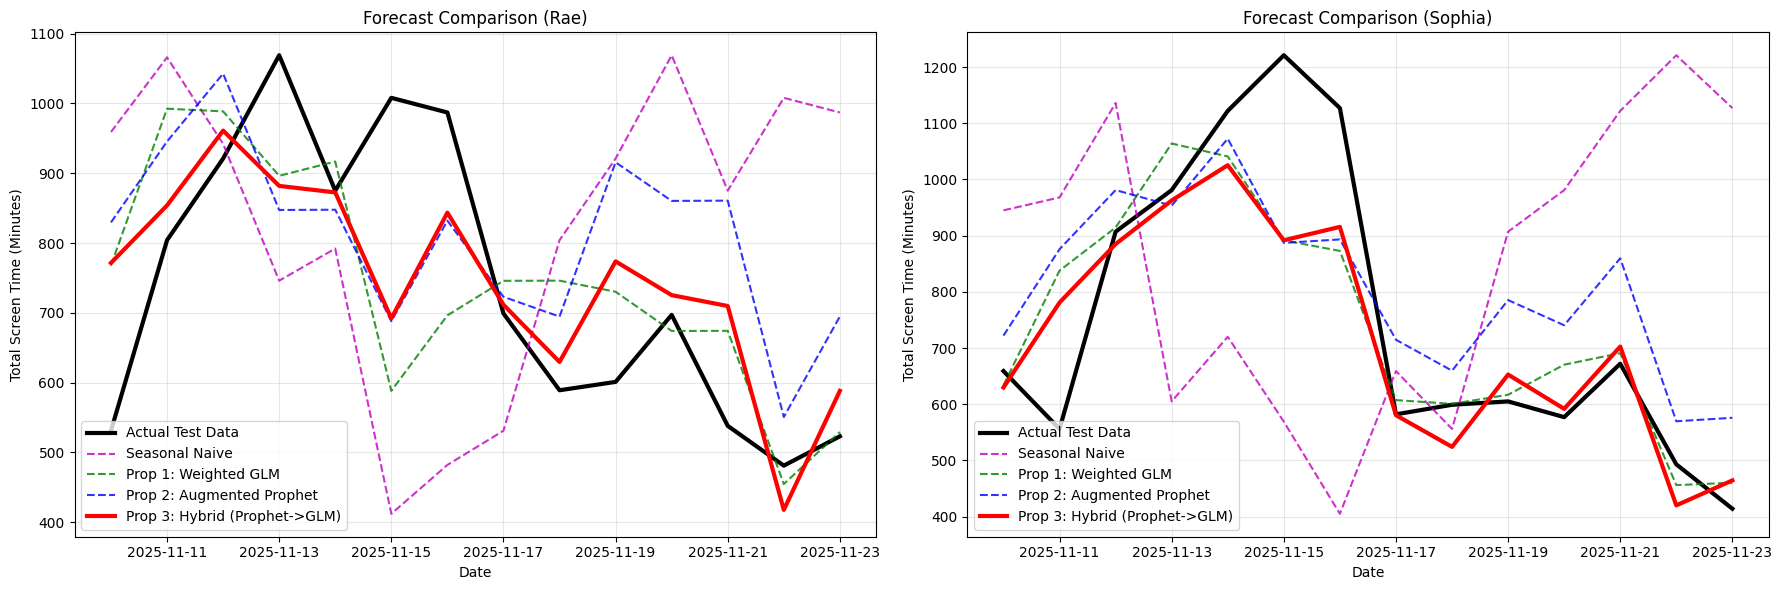

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import cvxpy as cp
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

warnings.filterwarnings("ignore")


# A. DATA PREPROCESSING & FEATURE ENGINEERING
def load_and_preprocess(filepath):
    """
    Loads the screen time dataset and engineers relevant features including
    calendar events, weekly seasonality (Fourier terms), and urgency signals.
    """
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
    df = df.sort_values('Date').reset_index(drop=True)
    
    # Standardize column names
    df = df.rename(columns={
        'Total Screen Time': 'y',
        'Weekdays (1: Weekdays; 0: Weekend)': 'is_weekday',
        'Exam Week (1: Yes; 0: No)': 'exam',
        'Reading Week (1: Yes; 0: No)': 'reading',
        'Assignment': 'assignment'
    })
    
    # --- Urgency Features (The "Cramming Curve") ---
    # Create flags
    df['urgent_deadline'] = 0
    df['urgent_prep'] = 0
    
    N = len(df)
    for t in range(N):
        if df.loc[t, 'assignment'] == 1:
            if t + 1 < N: df.loc[t+1, 'urgent_prep'] = 1
            if t + 2 < N: df.loc[t+2, 'urgent_deadline'] = 1

    # --- Weekday & Interactions ---
    df['dow'] = df['Date'].dt.dayofweek
    df['is_weekend'] = (df['dow'] >= 5).astype(int)
    
    # Interaction: "Weekend Crunch" - captures high usage on weekends if deadline looms
    df['inter_weekend_deadline'] = df['is_weekend'] * df['urgent_deadline']
    df['inter_weekend_prep'] = df['is_weekend'] * df['urgent_prep']
    
    # --- Seasonality (For GLM) ---
    # Fourier terms to model smooth weekly cycles
    df['cos_weekly'] = np.cos(2 * np.pi * df['dow'] / 7)
    df['sin_weekly'] = np.sin(2 * np.pi * df['dow'] / 7)
    
    return df


# B. MODELING FUNCTIONS (GLM & Optimization)
def evaluate_forecast(y_true, y_pred, method_name, print_output=False):
    """
    Calculates MAE and RMSE for a given forecast.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    if print_output:
        print(f"--- {method_name} Results ---")
        print(f"MAE:  {mae:.2f}")
        print(f"RMSE: {rmse:.2f}\n")
    return {'Method': method_name, 'MAE': mae, 'RMSE': rmse}

def fit_weighted_glm_poisson(df_train, lambda_tv, alpha=0.1):
    """
    Fits the Total-Variation Regularized GLM (Proposed Method 1).
    Uses a Poisson loss function suitable for count-like data (minutes).
    """
    valid_train = df_train.iloc[7:].copy() # Skip first week for lags
    T = len(valid_train)
    
    # Define Regressors
    struct_cols = ['cos_weekly', 'sin_weekly', 'is_weekend', 
                   'exam', 'reading', 
                   'assignment', 'urgent_prep', 'urgent_deadline',
                   'inter_weekend_deadline', 'inter_weekend_prep']
    
    # Add Lags and Velocity
    l1 = df_train['y'].shift(1).iloc[7:].values
    l7 = df_train['y'].shift(7).iloc[7:].values
    velocity = l1 - df_train['y'].shift(2).iloc[7:].values
    
    struct_vals = valid_train[struct_cols].values
    X = np.column_stack([struct_vals, l1, l7, velocity])
    Y = valid_train['y'].values
    D = X.shape[1]
    
    # Weights: Emphasize stress days (Exams/Deadlines) 3x more
    weights = np.ones(T)
    mask_stress = (valid_train['exam'] == 1) | (valid_train['urgent_deadline'] == 1)
    weights[mask_stress] = 3.0
    
    # Optimization Setup (CVXPY)
    Beta = cp.Variable(D)
    Mu = cp.Variable(T) # Time-varying intercept
    eta = X @ Beta + Mu
    
    # Poisson Loss: sum(w * (e^eta - Y * eta))
    term = cp.exp(eta) - cp.multiply(Y, eta)
    loss = cp.sum(cp.multiply(weights, term))
    
    # Regularization: TV on Mu (smoothness/changepoints) + Ridge on Beta
    diff = Mu[1:] - Mu[:-1]
    tv = lambda_tv * cp.norm(diff, 1)
    reg = alpha * cp.sum_squares(Beta)
    
    prob = cp.Problem(cp.Minimize(loss + tv + reg))
    try: prob.solve(verbose=False)
    except: prob.solve(solver=cp.SCS, verbose=False)
        
    return Beta.value, Mu.value

def fit_residual_glm(df_train, residuals, lambda_tv, alpha=0.1):
    """
    Fits a GLM on the RESIDUALS of another model (Proposed Method 3).
    Uses Gaussian (Least Squares) loss because residuals can be negative.
    """
    valid_train = df_train.iloc[7:].copy()
    T = len(valid_train)
    
    # Features (Same structure as Poisson GLM)
    struct_cols = ['cos_weekly', 'sin_weekly', 'is_weekend', 
                   'exam', 'reading', 
                   'assignment', 'urgent_prep', 'urgent_deadline',
                   'inter_weekend_deadline', 'inter_weekend_prep']
    
    # Lags of the RAW SIGNAL 'y' to predict the residual
    l1 = df_train['y'].shift(1).iloc[7:].values
    l7 = df_train['y'].shift(7).iloc[7:].values
    velocity = l1 - df_train['y'].shift(2).iloc[7:].values
    
    struct_vals = valid_train[struct_cols].values
    X = np.column_stack([struct_vals, l1, l7, velocity])
    
    # Target is Residuals
    Y_res = residuals[7:] 
    D = X.shape[1]
    
    # Weights
    weights = np.ones(T)
    mask_stress = (valid_train['exam'] == 1) | (valid_train['urgent_deadline'] == 1)
    weights[mask_stress] = 3.0
    
    # Optimization (Least Squares)
    Beta = cp.Variable(D)
    Mu = cp.Variable(T)
    
    pred = X @ Beta + Mu
    # Weighted MSE
    loss = cp.sum(cp.multiply(weights, cp.square(Y_res - pred)))
    
    diff = Mu[1:] - Mu[:-1]
    tv = lambda_tv * cp.norm(diff, 1)
    reg = alpha * cp.sum_squares(Beta)
    
    prob = cp.Problem(cp.Minimize(loss + tv + reg))
    try: prob.solve(verbose=False)
    except: prob.solve(solver=cp.SCS, verbose=False)
        
    return Beta.value, Mu.value


# C. MAIN PIPELINE WRAPPER
def run_forecasting_pipeline(filename, participant_name):
    """
    Runs the full analysis pipeline for a single participant:
    1. Loads data
    2. Runs Baselines (S.Naive, Prophet, SARIMA)
    3. Runs Proposed Models (GLM, Aug Prophet, Hybrid)
    4. Returns results table and plot data
    """
    print(f"\nProcessing {participant_name} ({filename})...")
    
    # 1. Load
    df = load_and_preprocess(filename)
    split_date = pd.Timestamp('2025-11-09')
    train = df[df['Date'] <= split_date].copy()
    test = df[df['Date'] > split_date].copy()
    print(f"Train Size: {len(train)}, Test Size: {len(test)}")
    
    results = []
    
    # --- Baselines ---
    
    # A. Seasonal Naive
    y_pred_snaive = []
    full_hist = pd.concat([train, test]).reset_index(drop=True)
    for idx in test.index:
        y_pred_snaive.append(full_hist.loc[idx - 7, 'y'])
    results.append(evaluate_forecast(test['y'], y_pred_snaive, "Seasonal Naive"))

    # B. Prophet (Baseline)
    prophet_train = train[['Date', 'y']].rename(columns={'Date': 'ds'})
    prophet_test = test[['Date', 'y']].rename(columns={'Date': 'ds'})
    m = Prophet(weekly_seasonality=True, daily_seasonality=False)
    m.fit(prophet_train)
    y_pred_prophet = m.predict(prophet_test)['yhat'].values
    results.append(evaluate_forecast(test['y'], y_pred_prophet, "Prophet (Baseline)"))

    # C. SARIMA
    model_sarima = SARIMAX(train['y'], order=(1, 0, 1), seasonal_order=(0, 1, 0, 7),
                           enforce_stationarity=False, enforce_invertibility=False)
    sarima_fit = model_sarima.fit(disp=False)
    y_pred_sarima = sarima_fit.get_forecast(steps=len(test)).predicted_mean.values
    results.append(evaluate_forecast(test['y'], y_pred_sarima, "SARIMA"))

    # --- Proposed 1: Weighted GLM ---
    Beta_glm, Mu_glm = fit_weighted_glm_poisson(train, lambda_tv=10)
    
    # Forecast Loop (Autoregressive)
    hist = train.copy()
    y_pred_glm = []
    slope_glm = (np.mean(Mu_glm[-3:]) - np.mean(Mu_glm[-14:])) / 11
    mu_last_glm = np.mean(Mu_glm[-3:])
    
    for i in range(len(test)):
        row = test.iloc[i]
        l1, l7 = hist['y'].iloc[-1], hist['y'].iloc[-7]
        velocity = l1 - hist['y'].iloc[-2]
        
        feats = [row['cos_weekly'], row['sin_weekly'], row['is_weekend'],
                 row['exam'], row['reading'], 
                 row['assignment'], row['urgent_prep'], row['urgent_deadline'],
                 row['inter_weekend_deadline'], row['inter_weekend_prep'],
                 l1, l7, velocity]
        
        mu_t = mu_last_glm + (slope_glm * (i+1) * (0.95**(i+1)))
        eta = np.dot(feats, Beta_glm) + mu_t
        val = np.clip(np.exp(eta), 0, 1440)
        
        new_row = row.copy(); new_row['y'] = val
        hist = pd.concat([hist, pd.DataFrame([new_row])], ignore_index=True)
        y_pred_glm.append(val)
    results.append(evaluate_forecast(test['y'], y_pred_glm, "Proposed 1: Weighted GLM"))

    # --- Proposed 2: Augmented Prophet ---
    aug_cols = ['exam', 'reading', 'assignment', 'urgent_prep', 'urgent_deadline', 
                'inter_weekend_deadline', 'inter_weekend_prep']
    train_aug = train[['Date', 'y'] + aug_cols].rename(columns={'Date': 'ds'})
    test_aug = test[['Date', 'y'] + aug_cols].rename(columns={'Date': 'ds'})
    
    m_aug = Prophet(weekly_seasonality=True, daily_seasonality=False)
    for col in aug_cols: m_aug.add_regressor(col)
    m_aug.fit(train_aug)
    y_pred_aug_prophet = np.clip(m_aug.predict(test_aug)['yhat'].values, 0, 1440)
    results.append(evaluate_forecast(test['y'], y_pred_aug_prophet, "Proposed 2: Aug Prophet"))

    # --- Proposed 3: Hybrid (Prophet -> GLM) ---
    # 1. Get fit from Augmented Prophet on TRAINING data
    prophet_base_preds_train = m_aug.predict(train_aug)['yhat'].values
    # 2. Get fit from Augmented Prophet on TEST data (Base Forecast)
    prophet_base_preds_test = y_pred_aug_prophet
    
    # 3. Calculate Residuals
    residuals_train = train['y'].values - prophet_base_preds_train
    
    # 4. Train GLM on Residuals
    Beta_res, Mu_res = fit_residual_glm(train, residuals_train, lambda_tv=10)
    
    # 5. Forecast Residuals & Combine
    hist = train.copy()
    y_pred_hybrid = []
    slope_res = (np.mean(Mu_res[-3:]) - np.mean(Mu_res[-14:])) / 11
    mu_last_res = np.mean(Mu_res[-3:])
    
    for i in range(len(test)):
        row = test.iloc[i]
        base_pred = prophet_base_preds_test[i]
        
        # Calculate GLM correction
        l1, l7 = hist['y'].iloc[-1], hist['y'].iloc[-7]
        velocity = l1 - hist['y'].iloc[-2]
        
        feats = [row['cos_weekly'], row['sin_weekly'], row['is_weekend'],
                 row['exam'], row['reading'], 
                 row['assignment'], row['urgent_prep'], row['urgent_deadline'],
                 row['inter_weekend_deadline'], row['inter_weekend_prep'],
                 l1, l7, velocity]
        
        mu_t = mu_last_res + (slope_res * (i+1) * 0.95**(i+1))
        correction = np.dot(feats, Beta_res) + mu_t
        
        # Final = Base + Correction
        final_pred = np.clip(base_pred + correction, 0, 1440)
        
        new_row = row.copy(); new_row['y'] = final_pred
        hist = pd.concat([hist, pd.DataFrame([new_row])], ignore_index=True)
        y_pred_hybrid.append(final_pred)
        
    results.append(evaluate_forecast(test['y'], y_pred_hybrid, "Proposed 3: Hybrid (Prophet->GLM)"))
    
    # Bundle Data for Plotting
    plot_data = {
        'Date': test['Date'],
        'Actual': test['y'],
        'S.Naive': y_pred_snaive,
        'GLM': y_pred_glm,
        'Aug Prophet': y_pred_aug_prophet,
        'Hybrid': y_pred_hybrid
    }
    
    return pd.DataFrame(results), plot_data


# D. EXECUTION

# Run Pipelines for both participants
res_rae, plot_rae = run_forecasting_pipeline('dataset_rae.csv', 'Rae')
res_sophia, plot_sophia = run_forecasting_pipeline('dataset_sophia.csv', 'Sophia')

# Print Final Tables
print("\n" + "-"*20 + " FINAL RESULTS: RAE " + "-"*20)
print(res_rae)
print("\n" + "-"*20 + " FINAL RESULTS: SOPHIA " + "-"*20)
print(res_sophia)

# Combined Plotting Logic (Two Subplots)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot Rae
ax = axes[0]
ax.plot(plot_rae['Date'], plot_rae['Actual'], 'k', linewidth=3, label='Actual Test Data')
ax.plot(plot_rae['Date'], plot_rae['S.Naive'], 'm--', alpha=0.8, label='Seasonal Naive')
ax.plot(plot_rae['Date'], plot_rae['GLM'], 'g--', alpha=0.8, label='Prop 1: Weighted GLM')
ax.plot(plot_rae['Date'], plot_rae['Aug Prophet'], 'b--', alpha=0.8, label='Prop 2: Augmented Prophet')
ax.plot(plot_rae['Date'], plot_rae['Hybrid'], 'r', linewidth=3, label='Prop 3: Hybrid (Prophet->GLM)')
ax.set_title("Forecast Comparison (Rae)")
ax.set_xlabel("Date")
ax.set_ylabel("Total Screen Time (Minutes)")
ax.grid(True, alpha=0.3)
ax.legend()

# Plot Sophia
ax = axes[1]
ax.plot(plot_sophia['Date'], plot_sophia['Actual'], 'k', linewidth=3, label='Actual Test Data')
ax.plot(plot_sophia['Date'], plot_sophia['S.Naive'], 'm--', alpha=0.8, label='Seasonal Naive')
ax.plot(plot_sophia['Date'], plot_sophia['GLM'], 'g--', alpha=0.8, label='Prop 1: Weighted GLM')
ax.plot(plot_sophia['Date'], plot_sophia['Aug Prophet'], 'b--', alpha=0.8, label='Prop 2: Augmented Prophet')
ax.plot(plot_sophia['Date'], plot_sophia['Hybrid'], 'r', linewidth=3, label='Prop 3: Hybrid (Prophet->GLM)')
ax.set_title("Forecast Comparison (Sophia)")
ax.set_xlabel("Date")
ax.set_ylabel("Total Screen Time (Minutes)")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()